# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [31]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [32]:
bandit0 = BanditProblem(0)

In [33]:
bandit0.get_num_arms()

3

In [34]:
bandit0.get_reward(arm=0)

1.8255111545554434

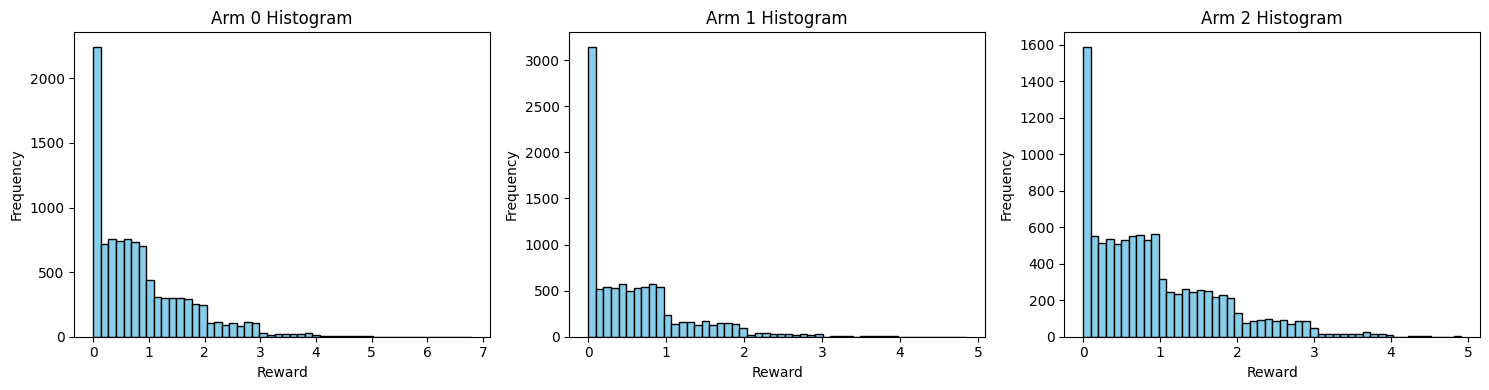

In [35]:
# YOUR CHANGES HERE

import matplotlib.pyplot as plt
bandit = BanditProblem(seed=0)
num_samples = 10000
rewards = {i: [] for i in range(bandit.get_num_arms())}

for i in range(num_samples):
    for arm in range(bandit.get_num_arms()):
        rewards[arm].append(bandit.get_reward(arm))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for arm in range(bandit.get_num_arms()):
    axes[arm].hist(rewards[arm], bins=50, color='skyblue', edgecolor='black')
    axes[arm].set_title(f"Arm {arm} Histogram")
    axes[arm].set_xlabel("Reward")
    axes[arm].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and gives a few sentences justifying your choice and rejecting the alternatives.
Keep your explanation concise; overly verbose responses will be penalized.

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2025002.

In [36]:
# YOUR CHANGES HERE

np.random.seed(2025002)
bandit = BanditProblem(seed=2025002)

num_arms = bandit.get_num_arms()
counts = np.zeros(num_arms)
rewards = [[] for _ in range(num_arms)]

actions = []
reward_history = []

for t in range(1000):
    samples = []
    for arm in range(num_arms):
        if counts[arm] < 2:
            sample = np.random.rand()
        else:
            mean = np.mean(rewards[arm])
            std = np.std(rewards[arm]) / np.sqrt(len(rewards[arm]))
            std = max(std, 1e-3)
            sample = np.random.normal(mean, std)
        samples.append(sample)

    chosen_arm = np.argmax(samples)
    reward = bandit.get_reward(chosen_arm)

    actions.append(chosen_arm)
    reward_history.append(reward)
    counts[chosen_arm] += 1
    rewards[chosen_arm].append(reward)

print("reward:", np.sum(reward_history))
for i in range(num_arms):
    print(f"Arm {i}: Pulled {int(counts[i])} times, Mean reward = {np.mean(rewards[i]):.4f}")



reward: 556.2845059212625
Arm 0: Pulled 708 times, Mean reward = 0.5672
Arm 1: Pulled 279 times, Mean reward = 0.5419
Arm 2: Pulled 13 times, Mean reward = 0.2708


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [37]:
# YOUR CHANGES HERE
import pandas as pd 

df = pd.DataFrame({
    'action': actions,
    'reward': reward_history
})

df.to_csv('history.tsv', sep='\t', index=False)


Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [38]:
# YOUR CHANGES HERE

import pandas as pd

part_3_summary_data = []
for arm in range(num_arms):
    arm_rewards = rewards[arm]
    if arm_rewards:
        part_3_summary_data.append({
            "action": arm,
            "min_reward": np.min(arm_rewards),
            "mean_reward": np.mean(arm_rewards),
            "max_reward": np.max(arm_rewards)
        })
    else:
        part_3_summary_data.append({
            "action": arm,
            "min_reward": None,
            "mean_reward": None,
            "max_reward": None
        })

df_summary = pd.DataFrame(part_3_summary_data)
df_summary.to_csv("actions.tsv", sep="\t", index=False)

Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Calculate the expected regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

In [39]:
# YOUR CHANGES HERE

bandit = BanditProblem(seed=2025002)
num_arms = bandit.get_num_arms()

true_means = []
samples_per_arm = 100000
for arm in range(num_arms):
    rewards = [bandit.get_reward(arm) for _ in range(samples_per_arm)]
    true_means.append(np.mean(rewards))

best_mean = max(true_means)

df_actual = pd.read_csv("history.tsv", sep="\t")
actions_actual = df_actual["action"].to_numpy()

def compute_regret(actions, true_means):
    regret = 0
    regrets = []
    for a in actions:
        regret += best_mean - true_means[a]
        regrets.append(regret)
    return regret, regrets

# uniform action
np.random.seed(2025002)
actions_uniform = np.random.choice(num_arms, size=1000)
regret_uniform, _ = compute_regret(actions_uniform, true_means)

# just-i 
regret_just = []
for i in range(num_arms):
    actions_i = [i] * 1000
    r, _ = compute_regret(actions_i, true_means)
    regret_just.append(r)

# thompson sampling
regret_actual, _ = compute_regret(actions_actual, true_means)


print("Expected Regret for Each Strategy:")
print(f"uniform: {regret_uniform:.4f}")
for i, r in enumerate(regret_just):
    print(f"just-{i}: {r:.4f}")
print(f"thompson sampling: {regret_actual:.4f}")


Expected Regret for Each Strategy:
uniform: 132.6641
just-0: 0.0000
just-1: 30.5633
just-2: 369.0344
thompson sampling: 13.3246


Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [40]:
# YOUR CHANGES HERE

df_strategies = pd.DataFrame({
    "strategy": ["uniform"] + [f"just-{i}" for i in range(num_arms)] + ["actual"],
    "regret": [regret_uniform] + regret_just + [regret_actual]
})

df_strategies.to_csv("strategies.tsv", sep="\t", index=False)


Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.